누군가의 이메일 열람 행동이 기부로 이어지는지 가설 검정을 위한 합성 데이터 시뮬레이션

In [5]:
import numpy as np
import pandas as pd

In [8]:
# 회원 상태
years = ['2014', '2015', '2016', '2017', '2018']
memberStatus = ['bronze', 'silver', 'gold', 'inactive']

# np.random.choice의 p인수 조절 > 각 부류의 발생확률을 달리하여 데이터 생성
memberYears = np.random.choice(years, 1000, p=[0.1, 0.1, 0.15, 0.30, 0.35])
memberStats = np.random.choice(memberStatus, 1000, p=[0.5, 0.3, 0.1, 0.1])
yearJoined = pd.DataFrame({'yearJoined':memberYears,
                           'memberStatus' : memberStats})

yearJoined

,yearJoined,memberStatus
0,2018,silver
1,2018,silver
2,2017,inactive
3,2018,gold
4,2014,inactive
...,...,...
995,2018,silver
996,2015,silver
997,2018,gold
998,2018,inactive


주별 회원의 이메일 열람 시점을 나타내는 테이블 만들기 위한 행동 패턴 정의 :
* 이메일을 열람한 적이 없음
* 일정한 수준의 이메일 열람 및 참여율
* 참여 수준의 증가 또는 감소

In [7]:
NUM_EMAILS_SENT_WEEKLY = 3

# 이메일을 한 번도 열람하지 않은 회원
def never_opens(period_rng) :
    return []

# 매주 같은 양의 이메일을 열람한 회원
def constant_open_rate(period_rng) :
    n, p = NUM_EMAILS_SENT_WEEKLY, np.random.uniform(0, 1)
    num_opened = np.random.binomial(n, p, len(period_rng))
    return num_opened

# 매주 열람한 이메일의 양이 늘어나는 회원
def increasing_open_rate(period_rng) :
    return open_rate_with_factor_change(period_rng, np.random.uniform(1.01, 1.30))

# 매주 열람한 이메일의 양이 줄어드는 회원
def decreasing_open_rate(period_rng) :
    return open_rate_with_factor_change(period_rng, np.random.uniform(0.5, 0.99))

def open_rate_with_factor_change(period_rng, fac) :
    if len(period_rng) < 1 :
        return []
    times = np.random.randint(0, len(period_rng), int(0.1 * len(period_rng)))
    num_opened = np.zeros(len(period_rng))
    for prd in range(0, len(period_rng), 2) :
        try :
            n, p = NUM_EMAILS_SENT_WEEKLY, np.random.uniform(0, 1)
            num_opened[prd:(prd+2)] = np.random.binomial(n, p, 2)
            p = max(min(1, p*fac), 0)
        except :
            num_opened[prd] = np.random.binomial(n, p, 1)
    for t in range(len(times)) :
        num_opened[times[t]] = 0
    return num_opened

기부 행동 모델링 시스템 :
* 열람 횟수에 따른 기부 행동을 느슨하게 연결
* 회원 자격의 기간에 따라 기부의 전체 횟수 지정
* 회원별 재정상태 정의

In [9]:
## 기부 행동
def produce_donations(period_rng, member_behavior, num_emails, 
                      use_id, member_join_year):
    donation_amounts = np.array([0, 25, 50, 75, 100, 250, 500, 
                                 1000, 1500, 2000])
    member_has = np.random.choice(donation_amounts)
    email_fraction = num_emails / (NUM_EMAILS_SENT_WEEKLY * len(period_rng)) 
    member_gives = member_has * email_fraction
    member_gives_idx = np.where(member_gives >= donation_amounts)[0][-1]
    member_gives_idx = max(min(member_gives_idx,
                               len(donation_amounts) - 2),
                           1)
    num_times_gave = np.random.poisson(2) * (2018 - member_join_year)
    times = np.random.randint(0, len(period_rng), num_times_gave)
    dons = pd.DataFrame({'member'   : [],
                         'amount'   : [],
                         'timestamp': []})
    for n in range(num_times_gave):
        donation = donation_amounts[member_gives_idx + np.random.binomial(1, .3)]
        ts = str(period_rng[times[n]].start_time + random_weekly_time_delta())
        dons = dons.append(pd.DataFrame(
                  {'member' :[use_id],
                   'amount' :[donation],
                   'timestamp': [ts]}))

        if dons.shape[0] > 0:
            dons = dons[dons.amount != 0]
            ## we don't report zero donation events as this would not
            ## be recorded in a real world database 
            ## 기부액이 0인 경우에는 보고하지 않습니다.
            ## 실세계에서 다룰 때 이러한 정보는 데이터베이스에 반영되지 않습니다.
    
            return dons

In [12]:
def random_weekly_time_delta():
    days_of_week = [d for d in range(7)]
    hours_of_day = [h for h in range(11, 23)] 
    minute_of_hour = [m for m in range(60)] 
    second_of_minute = [s for s in range(60)]
    return pd.Timedelta(str(np.random.choice(days_of_week)) + " days" ) + pd.Timedelta(str(np.random.choice(hours_of_day)) + " hours" ) + pd.Timedelta(str(np.random.choice(minute_of_hour)) + " minutes") + pd.Timedelta(str(np.random.choice(second_of_minute)) + " seconds") 

In [20]:
behaviors        = [never_opens, 
                    constant_open_rate, 
                    increasing_open_rate, 
                    decreasing_open_rate] 
member_behaviors = np.random.choice(behaviors, 1000,
                                    [0.2, 0.5, 0.1, 0.2]) 

rng = pd.period_range('2015-02-14', '2018-06-01', freq = 'W')
emails = pd.DataFrame({'member'      : [],
                       'week'        : [],
                       'emailsOpened': []})	
donations = pd.DataFrame({'member'   : [],
                          'amount'   : [],
                          'tunestamp': []})	

for idx in range(yearJoined.shape[0]):
    ## randomly generate the date when a member would have joined
    ## 회원이 가입한 시기를 무작위로 생성합니다
    join_date = pd.Timestamp(yearJoined.iloc[idx].yearJoined) + pd.Timedelta(str(np.random.randint(0, 365)) + ' days')
    join_date = min(join_date, pd.Timestamp('2018-06-01')).to_period(freq='W')

    ## member should not have action timestamps before joining
    ## 가입 전 어떤 행동에 대한 타임스탬프도 가져서는 안됩니다
    member_rng = rng[rng > join_date] 

    if len(member_rng) < 1:
        continue

    info = member_behaviors[idx](member_rng) 
    if len(info) == len(member_rng):
        emails = emails.append(pd.DataFrame(
           {'member': [idx] * len(info),
            'week': [str(r.start_time) for r in member_rng],
            'emailsOpened': info})) 
        donations = donations.append(
           produce_donations(member_rng, member_behaviors[idx], 
                                sum(info), idx, join_date.year)) 

In [15]:
rng = pd.period_range('2015-02-14', '2018-06-01', freq = 'W')
rng

PeriodIndex(['2015-02-09/2015-02-15', '2015-02-16/2015-02-22',
             '2015-02-23/2015-03-01', '2015-03-02/2015-03-08',
             '2015-03-09/2015-03-15', '2015-03-16/2015-03-22',
             '2015-03-23/2015-03-29', '2015-03-30/2015-04-05',
             '2015-04-06/2015-04-12', '2015-04-13/2015-04-19',
             ...
             '2018-03-26/2018-04-01', '2018-04-02/2018-04-08',
             '2018-04-09/2018-04-15', '2018-04-16/2018-04-22',
             '2018-04-23/2018-04-29', '2018-04-30/2018-05-06',
             '2018-05-07/2018-05-13', '2018-05-14/2018-05-20',
             '2018-05-21/2018-05-27', '2018-05-28/2018-06-03'],
            dtype='period[W-SUN]', length=173, freq='W-SUN')

<AxesSubplot:xlabel='timestamp'>

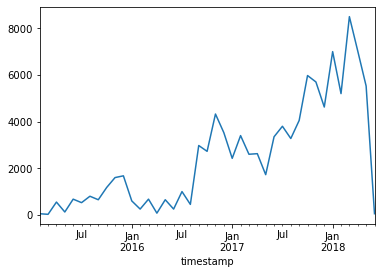

In [21]:
donations.set_index(pd.to_datetime(donations.timestamp), inplace = True) 
donations.sort_index(inplace = True)
donations.groupby(pd.Grouper(freq='M')).amount.sum().plot() 